In [ ]:
%cd ..

In [1]:
from argparse import ArgumentParser
from models.transferBigGAN import TransferBigGAN
from runner import setup_model
import visualizers
import yaml
from models import *
import models.BigGAN as biggan


In [4]:

args = {'filename': 'configs/animal_biggan.yaml', 'resume': 'D:\OneDrive - Hanoi University of Science and Technology\Downloads\\transfer-biggan2-epoch=699.ckpt'}
with open(args['filename'], 'r') as f:
    try:
        config = yaml.load(f.read(), Loader=yaml.FullLoader)
    except yaml.YAMLError as exc:
        print(exc)


ckpt_path = "D:\OneDrive - Hanoi University of Science and Technology\Downloads\\transfer-biggan2-epoch=699.ckpt"
biggan_pretrain_path = './data/G_ema.pth'
generator = biggan.Generator(**bigagn128config)
generator.load_state_dict(torch.load(
    biggan_pretrain_path, map_location=lambda storage, loc: storage))
model = TransferBigGAN.load_from_checkpoint(
    ckpt_path, generator=generator, data_size=config['data_model_params']['data_size'], **config['model_params'])


model.eval()

Adding attention layer in G at resolution 64


TransferBigGAN(
  (generator): Generator(
    (activation): ReLU(inplace=True)
    (linear): SNLinear(in_features=20, out_features=24576, bias=True)
    (blocks): ModuleList(
      (0): ModuleList(
        (0): GBlock(
          (activation): ReLU(inplace=True)
          (conv1): SNConv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): SNConv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv_sc): SNConv2d(1536, 1536, kernel_size=(1, 1), stride=(1, 1))
          (bn1): ccbn(
            out: 1536, in: 148, cross_replica=False
            (gain): SNLinear(in_features=148, out_features=1536, bias=False)
            (bias): SNLinear(in_features=148, out_features=1536, bias=False)
          )
          (bn2): ccbn(
            out: 1536, in: 148, cross_replica=False
            (gain): SNLinear(in_features=148, out_features=1536, bias=False)
            (bias): SNLinear(in_features=148, out_features=1536, bias=False)
         

In [ ]:
visualizers.random(model, "test/random.png")
visualizers.interpolate(model, "test/interpolate.png", 0, 10)
visualizers.reconstruct(model, "test/reconstruct.png",
                        [[0, 1, 2, 3], [0, 0, 0, 0]])

In [6]:
visualizers.reconstruct(model, "test/reconstruct9.png",
                        [[9], [0]])

In [7]:
import torch
import torchvision
from scipy.stats import truncnorm


def reconstruct(model, out_path, indices_labels, add_small_noise=False):
    with torch.no_grad():
        model.eval()
        device = next(model.parameters()).device
        dataset_size = model.embeddings.weight.size()[0]
        indices, labels = indices_labels
        if type(indices) != torch.Tensor:
            indices = torch.tensor(indices, device=device)
            labels = torch.tensor(labels, device=device)
        assert type(indices) == torch.Tensor
        indices = indices.to(device)
        embeddings = model.embeddings(indices)
        batch_size = embeddings.size()[0]

        # labels = [0, ] * batch_size
        # labels = torch.tensor(labels, device=device)
        labels = labels.to(device)
        labels_embeddings = model.class_embeddings(labels)

        if add_small_noise:
            embeddings += torch.randn(embeddings.size(), device=device)*0.01
        image_tensors = model(embeddings, labels_embeddings)
        return image_tensors

# see https://github.com/nogu-atsu/SmallGAN/blob/2293700dce1e2cd97e25148543532814659516bd/gen_models/ada_generator.py#L37-L53


def interpolate(model, out_path, source, dist, trncate=0.4, num=5):
    with torch.no_grad():
        model.eval()
        device = next(model.parameters()).device
        dataset_size = model.embeddings.weight.size()[0]
        indices = torch.tensor([source, dist], device=device)
        indices = indices.to(device)
        embeddings = model.embeddings(indices)
        embeddings = embeddings[[0]] * torch.linspace(1, 0, num, device=device)[
            :, None] + embeddings[[1]] * torch.linspace(0, 1, num, device=device)[:, None]

        batch_size = embeddings.size()[0]

        labels = [0, ] * batch_size
        labels = torch.tensor(labels, device=device)
        labels_embeddings = model.class_embeddings(labels)

        image_tensors = model(embeddings, labels_embeddings)
        return image_tensors

# from https://github.com/nogu-atsu/SmallGAN/blob/2293700dce1e2cd97e25148543532814659516bd/gen_models/ada_generator.py#L37-L53


def random(model, out_path, tmp=0.4, n=9, truncate=True):
    with torch.no_grad():
        model.eval()
        device = next(model.parameters()).device
        dataset_size = model.embeddings.weight.size()[0]
        dim_z = model.embeddings.weight.size(1)
        if truncate:
            embeddings = truncnorm(-tmp, tmp).rvs(n *
                                                  dim_z).astype("float32").reshape(n, dim_z)
        else:
            embeddings = np.random.normal(
                0, tmp, size=(n, dim_z)).astype("float32")
        embeddings = torch.tensor(embeddings, device=device)
        batch_size = embeddings.size()[0]

        labels = [0, 0, 0, 1, 1, 1, 2, 2, 2]
        labels = torch.tensor(labels, device=device)
        label_embeddings = model.class_embeddings(labels)

        image_tensors = model(embeddings, label_embeddings)
        return image_tensors


In [11]:
to_pil = torchvision.transforms.ToPILImage()
img = to_pil(torchvision.utils.make_grid(reconstruct(model, "test/reconstruct.png", [[0, 1, 2, 3], [0, 0, 0, 0]]), normalize=True))

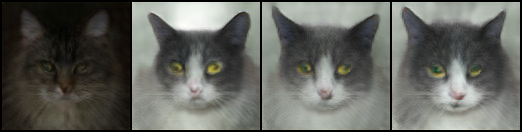

In [12]:
img

In [13]:
test = reconstruct(model, "test/reconstruct.png", [[0, 1, 2, 3], [0, 0, 0, 0]])

In [19]:
print(test[0].min())
print(test[0].max())

tensor(-0.8743)
tensor(-0.1876)


In [20]:
print(test[1].min())
print(test[1].max())

tensor(-0.7776)
tensor(0.5832)


In [16]:
to_mul_pic = lambda x : to_pil(torchvision.utils.make_grid(x, normalize=False))  
to_mul_pic_nor = lambda x : to_pil(torchvision.utils.make_grid(x, normalize=True))  

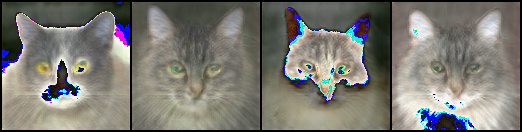

In [22]:
to_mul_pic(test)

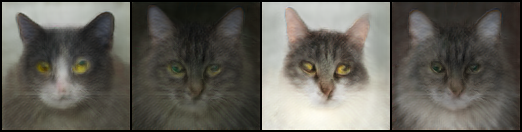

In [23]:
to_mul_pic_nor(test)

In [30]:
test = interpolate(model, "test/interpolate.png", 19, 37)

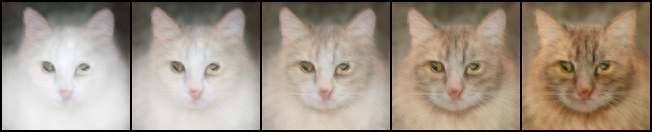

In [31]:
to_mul_pic_nor(test)